#Using machine learning techniques to predict compressional travel-time (DTC) in an offset well
    
 Purpose: Predicting acoustic slowness data from triple compbo logs based on ML model that was built on offset well                       logging data. SB16 well is used to build ML model. The model is then deployed to predict slowness data in SB17                 offsett well.
          This section includes data exploring, cleaning, correcting, completing, creating, converting, and deploying ML                 technique. 
 
 Data: The data used is available at https://certmapper.cr.usgs.gov/data/PubArchives/OF00-200/WELLS/WELLIDX.HTM
       Provided data is part of the USGS Open File Report 00-200 public dataset.
             
             
 Tools: Python, Jupyter Notebook, Pandas, Numpy, Lasio, Seaborn, Xgboost, MinMaxScaler, StandardScaler, Plotly, DBSCAN
 
 Improvements: ML Hyper parameter optimization
 

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import lasio
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image


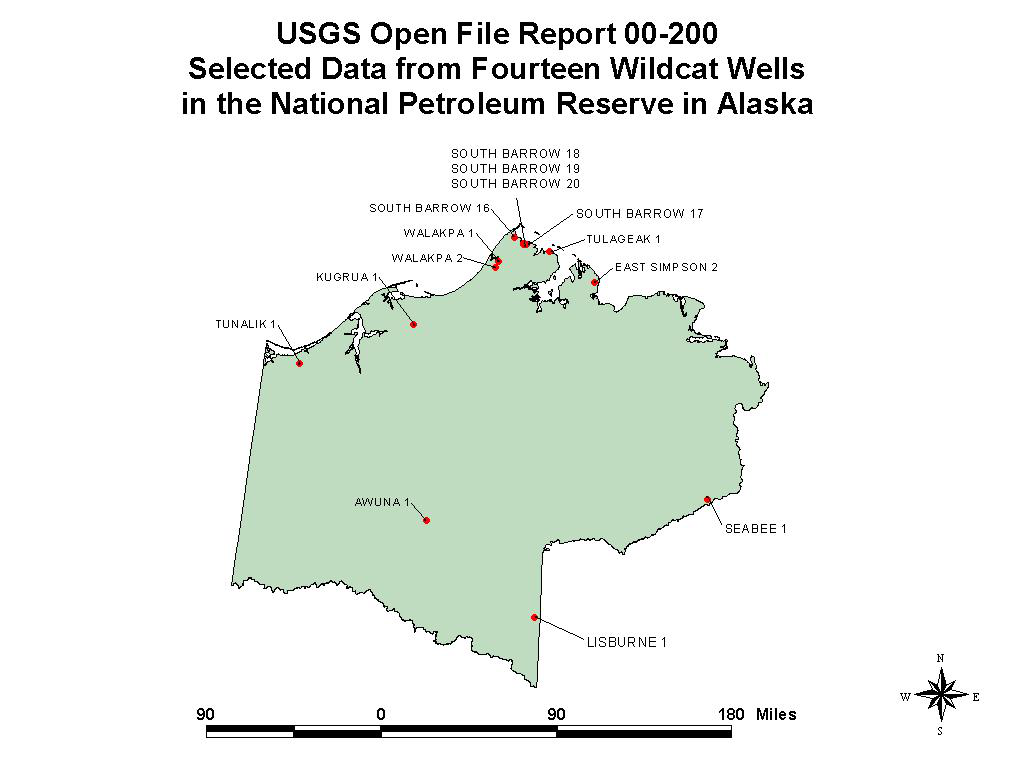

In [14]:
#location of wells
Image.open("LOCMAP.jpg")

In [15]:
las = lasio.read("SB18.las")
log.shape

(4053, 13)

In [16]:
log = las.df() #integration w/ pandas
log.loc[2000:2005]

SP       GR    CALI  BITSIZE  SFL_A  ILM  ILD      LLD      LLS  \
M__DEPTH                                                                    
2000.0   NaN  46.6325  9.2233      8.5    NaN  NaN  NaN  17.8402  15.2935   
2000.5   NaN  48.0986  9.1833      8.5    NaN  NaN  NaN  18.1110  15.3837   
2001.0   NaN  50.2337  9.1552      8.5    NaN  NaN  NaN  18.3859  15.4330   
2001.5   NaN  54.1031  9.1493      8.5    NaN  NaN  NaN  18.4816  15.7310   
2002.0   NaN  61.2546  9.1628      8.5    NaN  NaN  NaN  17.2641  15.1690   
2002.5   NaN  66.2626  9.1652      8.5    NaN  NaN  NaN  16.4467  14.6350   
2003.0   NaN  64.9143  9.1360      8.5    NaN  NaN  NaN  16.3388  14.6427   
2003.5   NaN  59.0609  9.1070      8.5    NaN  NaN  NaN  16.5757  14.7756   
2004.0   NaN  51.7669  9.0738      8.5    NaN  NaN  NaN  17.0061  15.1263   
2004.5   NaN  50.6995  9.0493      8.5    NaN  NaN  NaN  17.5573  15.4812   
2005.0   NaN  52.3375  9.0922      8.5    NaN  NaN  NaN  17.5676  15.6797   

            RHOB     NPHI         DT  MUDWGT  
M__DEPTH                                      
2000.0    2.3126  23.5249   98.66669    10.2  
2000.5    2.2983  23.7218   98.66669    10.2  
2001.0    2.2877  23.9619   98.41530    10.2  
2001.5    2.3099  24.7660  101.32890    10.2  
2002.0    2.3504  26.6600  102.89540    10.2  
2002.5    2.4087  27.2736  101.56480    10.2  
2003.0    2.4243  27.0587  102.22224    10.2  
2003.5    2.4100  27.1224  104.88892    10.2  
2004.0    2.3919  27.6658  104.54420    10.2  
2004.5    2.3987  26.5342  106.29910    10.2  
2005.0    2.4309  25.4105  104.54120    10.2

In [17]:
logs = log[['DT', 'NPHI', 'CALI', 'GR', 'RHOB', "BITSIZE"]]

In [18]:
logs = logs.reset_index()
logs=logs.rename(columns=({'M__DEPTH':'DEPT'}))
logs=logs.rename(columns=({'DT':'DTC'}))

In [19]:
logs = logs.dropna()
#dropping nan values is necessary for ML model building

In [20]:
print (logs.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1148 entries, 2857 to 4004
Data columns (total 7 columns):
DEPT       1148 non-null float64
DTC        1148 non-null float64
NPHI       1148 non-null float64
CALI       1148 non-null float64
GR         1148 non-null float64
RHOB       1148 non-null float64
BITSIZE    1148 non-null float64
dtypes: float64(7)
memory usage: 71.8 KB
None


In [21]:
logs.isnull().any()


DEPT       False
DTC        False
NPHI       False
CALI       False
GR         False
RHOB       False
BITSIZE    False
dtype: bool

In [22]:
logs.head()

DEPT       DTC     NPHI     CALI       GR    RHOB  BITSIZE
2857  1526.5  113.2361  40.1238  10.3533  94.5815  2.4668      8.5
2858  1527.0  114.2915  39.8644  10.8666  92.8286  2.4552      8.5
2859  1527.5  113.7983  40.6249  10.9610  91.6459  2.4585      8.5
2860  1528.0  112.8209  41.0680  10.5400  90.5465  2.4457      8.5
2861  1528.5  111.7979  41.1106  11.0248  88.9671  2.4281      8.5

In [23]:
fig = px.scatter_matrix(logs, dimensions=["DEPT","DTC","NPHI","CALI","GR","RHOB"], color="GR" )
fig.show()

In [24]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=logs["CALI"], y=logs["DEPT"],
                    mode='lines',
                    name='CALI'))
fig.add_trace(go.Scatter(x=logs["BITSIZE"], y=logs["DEPT"],
                    mode='lines',
                    name='BITSIZE'))
fig.add_trace(go.Scatter(x=[8,18], y=logs["DEPT"],
                    mode='markers',
                    name='Scale'))

In [25]:
fig = px.scatter(logs, x="CALI", y="RHOB", color="GR")
fig.show()

In [26]:
# dbscan clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt

# define dataset

X = logs["CALI"].values.reshape(-1, 1)
y = logs["RHOB"].values.reshape(-1, 1)

model = DBSCAN(eps=0.09, min_samples=20)
yhat = model.fit_predict(X, y)
clusters = unique(yhat)

fig = px.scatter(logs, logs["CALI"], logs["RHOB"], color=yhat)
fig.show()


In [27]:
def plot(logs):
    #to make sure logs are sorted by depth
    logs = logs.sort_values(by='DEPT')
    
    ltop=logs.DEPT.min(); lbot=logs.DEPT.max()
    
    f, ax = plt.subplots(nrows=1, ncols=5, figsize=(10, 10))
    ax[0].plot(logs.GR, logs.DEPT, '-g')
    ax[1].plot(logs.CALI, logs.DEPT, '-')
    ax[2].plot(logs.DTC, logs.DEPT, '-', color='0.5')
    ax[3].plot(logs.RHOB, logs.DEPT, '-', color='r')
    ax[4].plot(logs.NPHI, logs.DEPT, '-', color='blue')
    
        
    for i in range(len(ax)):
        ax[i].set_ylim(ltop,lbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("CALI")
    ax[1].set_xlabel("CALI")
    ax[1].set_xlim(6,16)
    ax[1].set_xlim(6,16)
    ax[2].set_xlabel("DTC")
    ax[2].set_xlim(logs.DTC.min(),logs.DTC.max())
    ax[3].set_xlabel("RHOB")
    ax[3].set_xlim(logs.RHOB.min(),logs.RHOB.max())
    ax[4].set_xlabel("NPHI")
    ax[4].set_xlim(logs.NPHI.min(),logs.NPHI.max())

    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([])


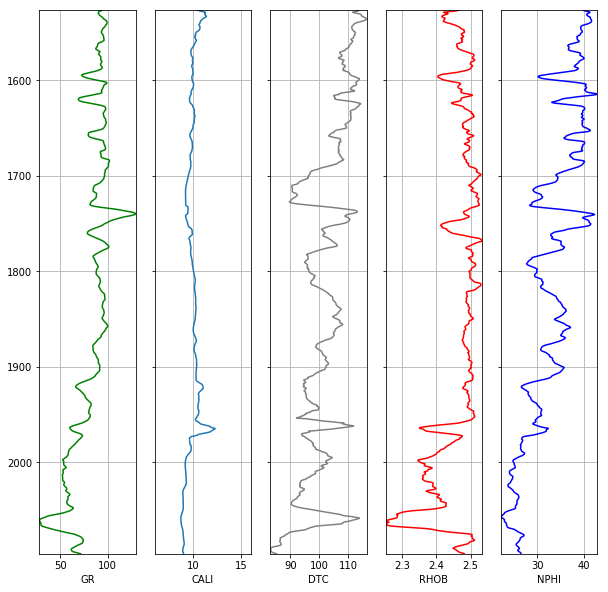

In [28]:
#Despiking logs - Improves model accuarrcy and predictions
loglst = list(logs)

logs = logs.copy(deep=True)
window = 17
for i in loglst:
    logs[i] = pd.Series(logs[i]).rolling(window=window, min_periods=1).mean()

#plotting after despking
plot(logs)

In [29]:
import seaborn as sns

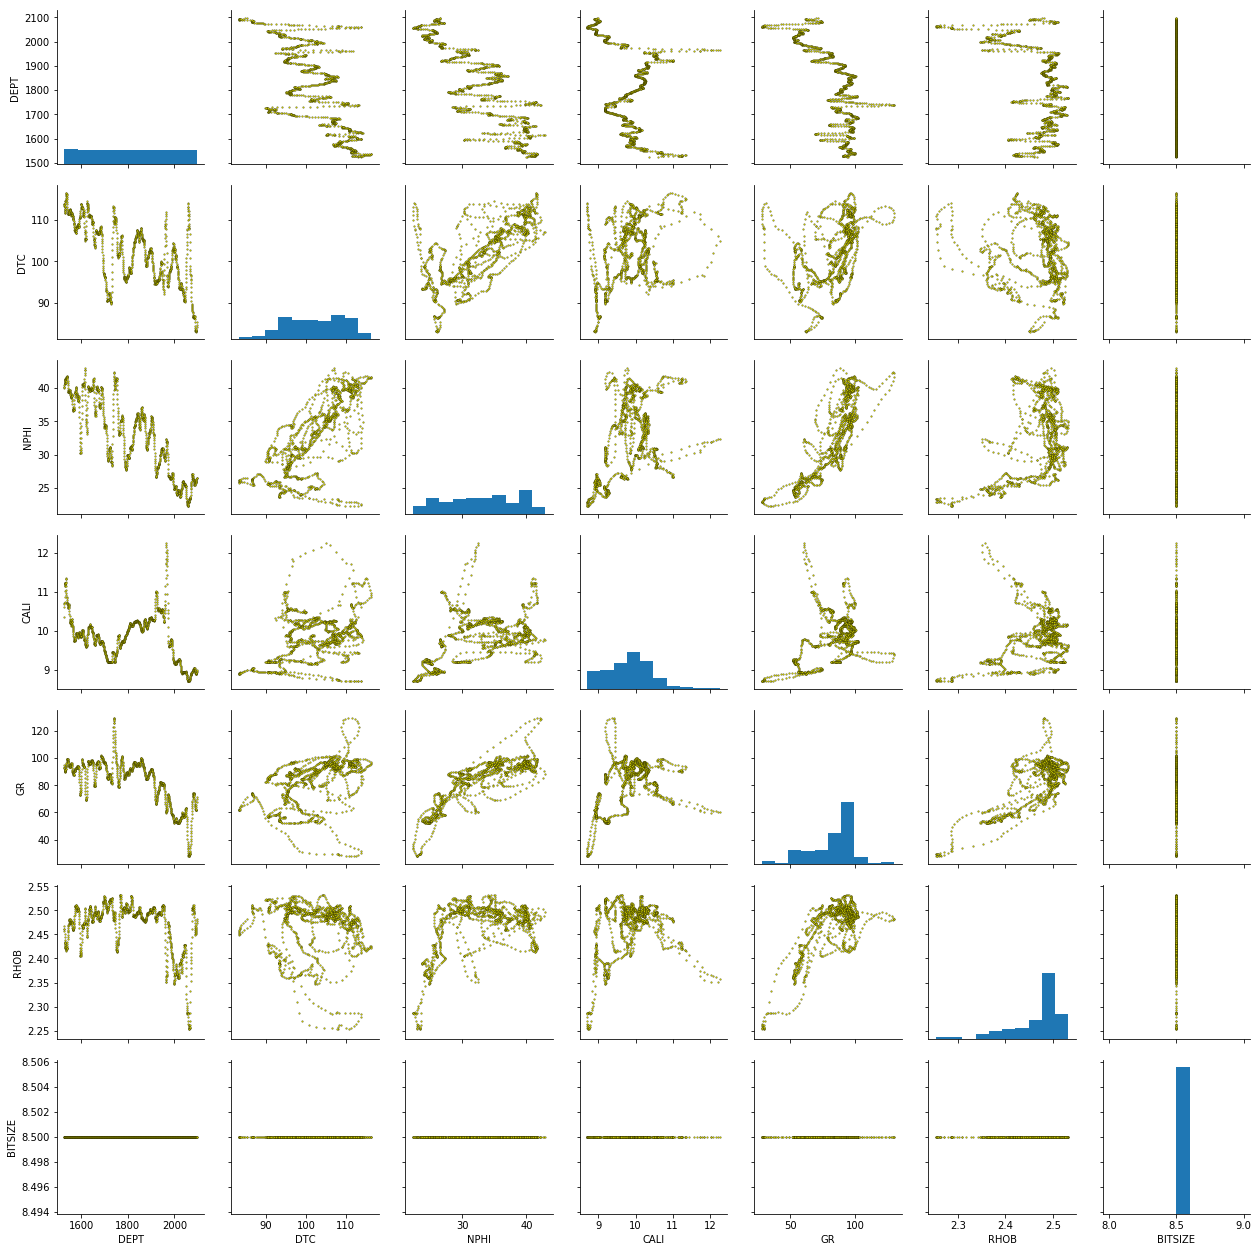

In [30]:
g = sns.PairGrid(logs)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter, s=3, color = "y", edgecolor="k", linewidth= 0.2);

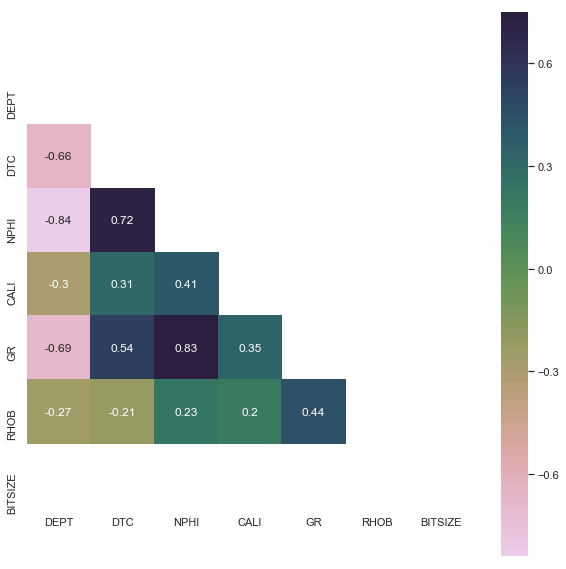

In [31]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(logs.corr(method = 'spearman') , dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.cubehelix_palette(n_colors=12, start=-2.25, rot=-1.3, as_cmap=True)

plt.subplots(figsize=(10,10))

# Draw the heatmap (spearman corrected) with the mask and correct aspect ratio
sns.heatmap(logs.corr(method = 'spearman') ,annot=True,  mask=mask, cmap=cmap, vmax=0.75, square=True)

plt.show()

In [32]:
logs.head()

DEPT        DTC       NPHI       CALI         GR      RHOB  BITSIZE
2857  1526.50  113.23610  40.123800  10.353300  94.581500  2.466800      8.5
2858  1526.75  113.76380  39.994100  10.609950  93.705050  2.461000      8.5
2859  1527.00  113.77530  40.204367  10.726967  93.018667  2.460167      8.5
2860  1527.25  113.53670  40.420275  10.680225  92.400625  2.456550      8.5
2861  1527.50  113.18894  40.558340  10.749140  91.713920  2.450860      8.5

In [33]:
features = ['GR','CALI', 'NPHI', 'RHOB']
Target = ['DTC']

X=logs[features]
y=logs[Target]

In [34]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score


In [35]:
#Train Test
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25)

In [36]:
#Standard Scaler is used after train/test to avoid leakage
#For XGBOOST, scaling process is not necessary

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scmm = MinMaxScaler()
scss = StandardScaler()
train_Xmm = scmm.fit_transform(train_X)
test_Xmm = scmm.transform(test_X)
train_Xss = scss.fit_transform(train_X)
test_Xss = scss.transform(test_X)

In [37]:
XGB_model = XGBRegressor()
XGB_modelss = XGB_model.fit(train_Xss, train_y, verbose=False)
XGB_modelmm = XGB_model.fit(train_Xmm, train_y, verbose=False)

[11:08:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:08:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [38]:
DTC_Pmm = XGB_model.predict(test_Xmm)
print("Mean Absolute Error MinMaxScaler: " + str(mean_absolute_error(DTC_Pmm, test_y)))


Mean Absolute Error MinMaxScaler: 1.7175081319425545


In [39]:
DTC_Pss = XGB_model.predict(test_Xss)
print("Mean Absolute Error StandardScaler: " + str(mean_absolute_error(DTC_Pss, test_y)))

Mean Absolute Error StandardScaler: 6.8082040990949135


In [40]:
#Add model results to dataframe using entire data
#XGB_model = XGBRegressor()
XGB_modelmm.fit(X, y, verbose=False)
DTC_XGB = XGB_modelmm.predict(X)
logs['DTC_XGB'] = DTC_XGB
print("Mean Absolute Error : " + str(mean_absolute_error(DTC_XGB, y)))

[11:08:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error : 1.3189113541842838


C:\Users\pc\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1241: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.

C:\Users\pc\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



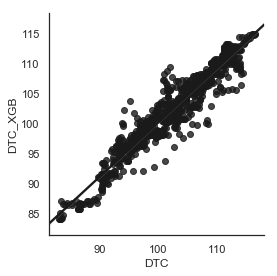

In [41]:
g = sns.PairGrid(logs, y_vars=["DTC_XGB"], x_vars=["DTC"], size=4)
g.map(sns.regplot, color="0.1")
plt.show()

C:\Users\pc\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



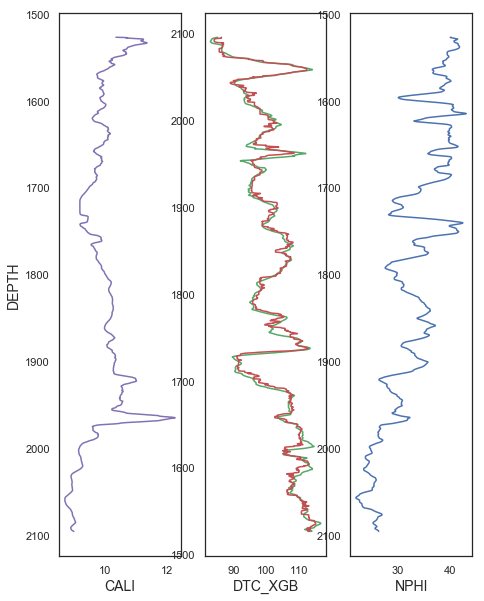

In [42]:
#Plotting Insample results
fig = plt.figure(figsize=(10, 10)) 

ax1 = fig.add_subplot(1, 4, 1)
ax1.plot(logs['CALI'], logs['DEPT'], color = 'm', alpha=1)
ax1.set_ylabel('DEPTH', fontsize = '14' )
ax1.set_xlabel('CALI', fontsize = '14')
plt.gca().invert_yaxis()

ax2 = fig.add_subplot(1, 4, 2)
ax2.plot(logs['DTC'], logs['DEPT'], color = 'g', alpha=1)
ax2.set_xlabel('DTC', fontsize = '14')
plt.gca().invert_yaxis()

ax3 = fig.add_subplot(1, 4, 2)
ax3.plot(logs['DTC_XGB'], logs['DEPT'], color = 'r', alpha=1)
ax3.set_xlabel('DTC_XGB', fontsize = '14')
plt.gca().invert_yaxis()

ax4 = fig.add_subplot(1, 4, 3)
ax4.plot(logs['NPHI'], logs['DEPT'], color = 'b', alpha=1)
ax4.set_xlabel('NPHI', fontsize = '14')
plt.gca().invert_yaxis()

plt.show()


In [43]:
# linreg model 
# iterate over possible number of cross validation folds to check scores and decide optimal fold 
from sklearn.linear_model import LinearRegression

Linreg = LinearRegression()

scorelinreg = []
for i in np.arange(2, 15, 1):
    score = cross_val_score(Linreg, X, y, cv=i)
    scorelinreg.append(np.mean(score))
    # Take the mean of the scores (because we have one for each fold)

print (scorelinreg)

[0.6008275124597461, 0.3406601571750434, -0.21863373105210632, -0.2643828995631633, 0.11977045421390926, -0.046743130454836725, 0.030177014711590455, -0.14228565534419782, -0.15842527197273024, -0.10028429714708893, -0.21163628971486256, -0.6401043256543903, -0.5996662952092019]


In [44]:
Linreg.fit(X, y)
DTC_Lin = Linreg.predict(X)
logs['DTC_Lin'] = DTC_Lin
print("Mean Absolute Error : " + str(mean_absolute_error(DTC_Lin, y)))

Mean Absolute Error : 2.7802673657840287


In [45]:
logs.head()

DEPT        DTC       NPHI       CALI         GR      RHOB  BITSIZE  \
2857  1526.50  113.23610  40.123800  10.353300  94.581500  2.466800      8.5   
2858  1526.75  113.76380  39.994100  10.609950  93.705050  2.461000      8.5   
2859  1527.00  113.77530  40.204367  10.726967  93.018667  2.460167      8.5   
2860  1527.25  113.53670  40.420275  10.680225  92.400625  2.456550      8.5   
2861  1527.50  113.18894  40.558340  10.749140  91.713920  2.450860      8.5   

         DTC_XGB     DTC_Lin  
2857  112.830849  111.450904  
2858  112.972603  112.232515  
2859  112.579109  112.633775  
2860  112.724312  113.026768  
2861  112.485558  113.743757

C:\Users\pc\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

C:\Users\pc\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



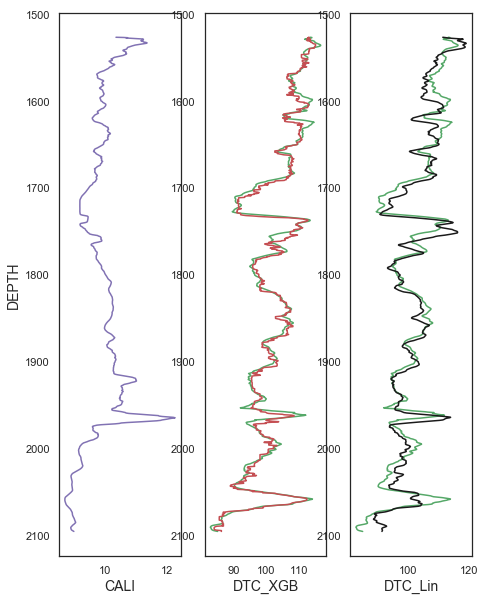

In [46]:
fig = plt.figure(figsize=(10, 10)) 

ax1 = fig.add_subplot(1, 4, 1)
ax1.plot(logs['CALI'], logs['DEPT'], color = 'm', alpha=1)
ax1.set_ylabel('DEPTH', fontsize = '14' )
ax1.set_xlabel('CALI', fontsize = '14')
plt.gca().invert_yaxis()

ax2 = fig.add_subplot(1, 4, 2)
ax2.plot(logs['DTC'], logs['DEPT'], color = 'g', alpha=1)
ax2.set_xlabel('DTC', fontsize = '14')
plt.gca().invert_yaxis()


ax3 = fig.add_subplot(1, 4, 2)
ax3.plot(logs['DTC_XGB'], logs['DEPT'], color = 'r', alpha=1)
ax3.set_xlabel('DTC_XGB', fontsize = '14')

ax4 = fig.add_subplot(1, 4, 3)
ax4.plot(logs['DTC'], logs['DEPT'], color = 'g', alpha=1)
ax4.set_xlabel('DTC', fontsize = '14')
plt.gca().invert_yaxis()

ax5 = fig.add_subplot(1, 4, 3)
ax5.plot(logs['DTC_Lin'], logs['DEPT'], color = 'k', alpha=1)
ax5.set_xlabel('DTC_Lin', fontsize = '14')

plt.show()

In [47]:
def error_flag(pred, actual, dev = 1.0, method = 1):
    flag = np.zeros(len(pred))
    err = np.abs(pred-actual)
    err_mean = np.mean(err)
    err_std = np.std(err)
    ss = np.sign(pred.diff().fillna(pred))
    ls = np.sign(actual.diff().fillna(actual))

    if method == 1:
        flag[np.where(err>(err_mean + (dev*err_std)))] = 1
    elif method == 2:      
        flag[np.where((ss + ls)==0 )]= 1
    elif method == 3:
        flag[np.where(np.logical_or(err>(err_mean + (dev*err_std)), (ss+ls)==0 ))]= 1
    return flag

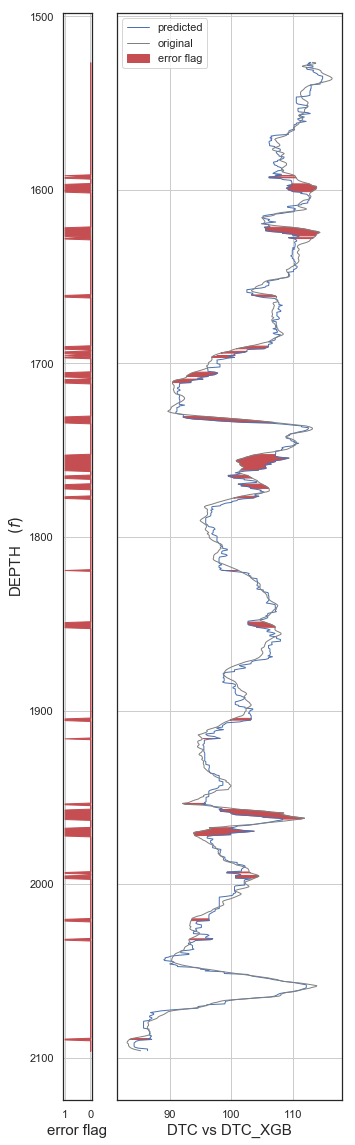

In [48]:
from matplotlib  import gridspec

flag = error_flag(logs["DTC_XGB"], logs["DTC"], 1,  1)


fig = plt.figure(figsize=(5,20))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.5, 4]) 
# https://stackoverflow.com/a/10411424

ax = plt.subplot(gs[0])
ax.set_ylabel(r'DEPTH   $(f)$', size=15)
ax.fill_betweenx(logs['DEPT'], flag, 0, color = 'r')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('error flag', size=15)

ax.grid()

ax1 = plt.subplot(gs[1])
ax1.plot(logs["DTC_XGB"], logs["DEPT"], 'b', label='predicted', linewidth = 1)
ax1.plot(logs["DTC"], logs["DEPT"], 'gray', label='original', linewidth = 1)
ax1.fill_betweenx(logs['DEPT'], logs["DTC_XGB"], logs["DTC"], where=flag==1, color = 'r', label='error flag')

# Do some plot annotations
#ax1.set_title('title here')
ax1.invert_yaxis()
ax1.set_yticklabels([])
ax1.set_xlabel('DTC vs DTC_XGB', size=15)

ax1.legend()
    
ax1.grid()
plt.show()

In [49]:
#Apply model to the offset well to predict DT 
las2 = lasio.read("SB19.las")
logs2 = las2.df()

In [50]:
logs2.describe()

SP           GR         CALI          LL8          ILM  \
count  4215.000000  4284.000000  4389.000000  2789.000000  2782.000000   
mean    -49.631584    75.149345    11.243064    15.513349     9.153284   
std       8.886931    15.176045     2.226316     9.610939     2.595218   
min     -65.798440    22.459800    -4.443300     4.838700     3.010400   
25%     -57.170260    69.028200     9.209000     9.755200     7.899950   
50%     -48.985420    78.388150    12.291700    11.045800     8.770400   
75%     -43.875205    83.177650    12.743800    17.127900     9.779650   
max     -21.535000   153.252300    16.008800    56.359100    27.297600   

               ILD          LLD          LLS         RHOB         NPHI  \
count  2781.000000  1579.000000  1579.000000  1603.000000  1553.000000   
mean     12.383945    20.801079    16.434292     2.480734    33.193522   
std       5.871958    31.853409    21.364192     0.085141     6.671936   
min       4.904900     2.622600     7.085700     2.221300     0.113900   
25%       9.215000    11.508500    10.671050     2.448050    27.937500   
50%      10.164700    14.298100    12.411000     2.483600    32.446100   
75%      13.981900    17.805400    16.034000     2.514350    38.767300   
max      61.345900   642.564700   198.225800     2.798400    49.705600   

                DT  
count  4381.000000  
mean    122.478196  
std      25.888103  
min      63.413900  
25%     103.147100  
50%     117.177100  
75%     146.439700  
max     188.827300

In [51]:
logs2 = logs2[['DT', 'NPHI', 'CALI', 'GR', 'RHOB']]

In [52]:
logs2 = logs2.reset_index()
logs2 =logs2.rename(columns=({'M__DEPTH':'DEPT'}))
logs2=logs2.rename(columns=({'DT':'DTC'}))

In [53]:
logs2 = logs2.dropna()
logs2.isnull().any()

DEPT    False
DTC     False
NPHI    False
CALI    False
GR      False
RHOB    False
dtype: bool

In [54]:
#Despiking logs - Improves model accuarrcy and predictions
loglst2 = list(logs2)

logs2 = logs2.copy(deep=True)
window = 17
for i in loglst2:
    logs2[i] = pd.Series(logs2[i]).rolling(window=window, min_periods=1).mean()

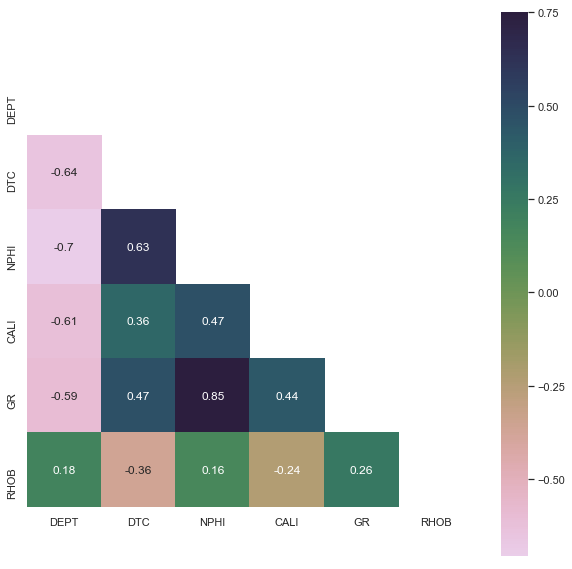

In [55]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(logs2.corr(method = 'spearman') , dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.cubehelix_palette(n_colors=12, start=-2.25, rot=-1.3, as_cmap=True)

plt.subplots(figsize=(10,10))

# Draw the heatmap (spearman corrected) with the mask and correct aspect ratio
sns.heatmap(logs2.corr(method = 'spearman') ,annot=True,  mask=mask, cmap=cmap, vmax=0.75, square=True)

plt.show()

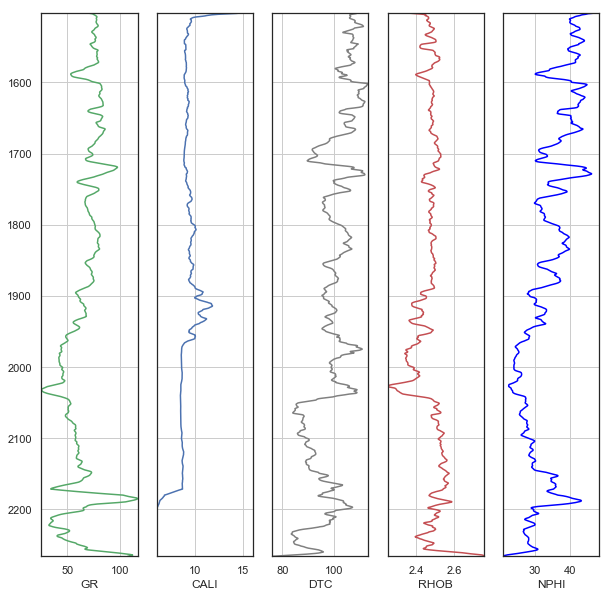

In [56]:
def plot(logs2):
    #make sure logs are sorted by depth
    logs2 = logs2.sort_values(by='DEPT')
    
    ltop=logs2.DEPT.min(); lbot=logs2.DEPT.max()
    
    f, ax = plt.subplots(nrows=1, ncols=5, figsize=(10, 10))
    ax[0].plot(logs2.GR, logs2.DEPT, '-g')
    ax[1].plot(logs2.CALI, logs2.DEPT, '-')
    ax[2].plot(logs2.DTC, logs2.DEPT, '-', color='0.5')
    ax[3].plot(logs2.RHOB, logs2.DEPT, '-', color='r')
    ax[4].plot(logs2.NPHI, logs2.DEPT, '-', color='blue')
    
        
    for i in range(len(ax)):
        ax[i].set_ylim(ltop,lbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs2.GR.min(),logs2.GR.max())
    ax[1].set_xlabel("CALI")
    ax[1].set_xlim(6,16)
    ax[2].set_xlabel("DTC")
    ax[2].set_xlim(logs2.DTC.min(),logs2.DTC.max())
    ax[3].set_xlabel("RHOB")
    ax[3].set_xlim(logs2.RHOB.min(),logs2.RHOB.max())
    ax[4].set_xlabel("NPHI")
    ax[4].set_xlim(logs2.NPHI.min(),logs2.NPHI.max())

    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([])
plot(logs2)

In [57]:
features2 = ['GR', 'CALI', 'NPHI', 'RHOB']
Target2 = ['DTC']

X2=logs2[features2]
y2=logs2[Target2]

In [58]:
DTC_XGB2 = XGB_model.predict(X2)
logs2['DTC_XGB2'] = DTC_XGB2
print("Mean Absolute Error : " + str(mean_absolute_error(DTC_XGB2, y2)))

Mean Absolute Error : 3.7690267305060203


C:\Users\pc\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



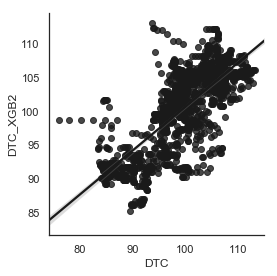

In [59]:
g = sns.PairGrid(logs2, y_vars=["DTC_XGB2"], x_vars=["DTC"], height=4)
g.map(sns.regplot, color="0.1")
plt.show()

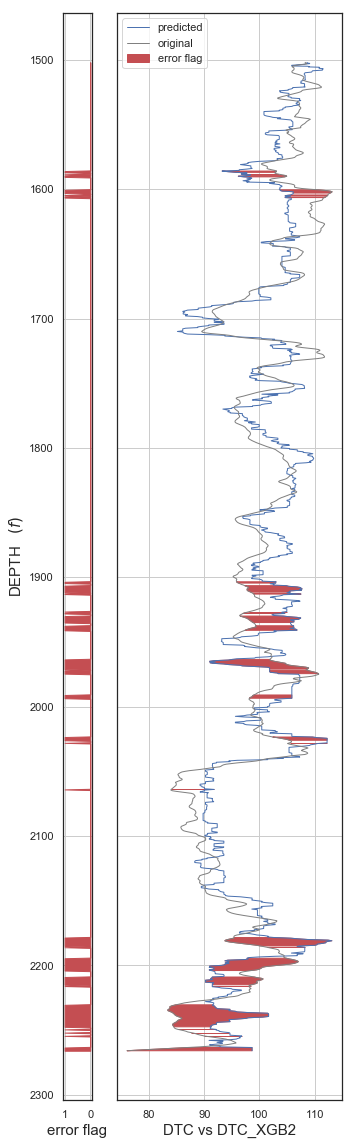

In [60]:
flag = error_flag(logs2["DTC_XGB2"], logs2["DTC"], 1,  1)


fig = plt.figure(figsize=(5,20))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.5, 4]) 
# https://stackoverflow.com/a/10411424

ax = plt.subplot(gs[0])
ax.set_ylabel(r'DEPTH   $(f)$', size=15)
ax.fill_betweenx(logs2['DEPT'], flag, 0, color = 'r')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('error flag', size=15)

ax.grid()

ax1 = plt.subplot(gs[1])
ax1.plot(logs2["DTC_XGB2"], logs2["DEPT"], 'b', label='predicted', linewidth = 1)
ax1.plot(logs2["DTC"], logs2["DEPT"], 'gray', label='original', linewidth = 1)
ax1.fill_betweenx(logs2['DEPT'], logs2["DTC_XGB2"], logs2["DTC"], where=flag==1, color = 'r', label='error flag')

# Do some plot annotations
#ax1.set_title('title here')
ax1.invert_yaxis()
ax1.set_yticklabels([])
ax1.set_xlabel('DTC vs DTC_XGB2', size=15)

ax1.legend()
    
ax1.grid()
plt.show()
